In [571]:
# importing libraries
import numpy as np  
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [572]:
# defining the helper functions

In [573]:
# oscillator wrapper function takes in an array of oscillating species names, array of doped species, current timestep

def oscillator_function(y,t,num_oscillating_species):
    # making the array of the oscillating species
    oscillating_species = y[0:num_oscillating_species]
    doped_species = y[num_oscillating_species:]

    num_doped_species = len(doped_species)

    # initialisinng the derivatives
    d_oscillating_species = np.zeros(num_oscillating_species)
    d_doped_species = np.zeros(num_doped_species)

    # defining the derivatives 

    # for the oscillating species
    d_oscillating_species[0] = -oscillating_species[0]*oscillating_species[1] + oscillating_species[num_oscillating_species-1]*oscillating_species[0] + doped_species[0]*oscillating_species[num_oscillating_species-1] - doped_species[1]*oscillating_species[0]

    for idx in range(1,num_oscillating_species-1):
        d_oscillating_species[idx] = oscillating_species[idx-1]*oscillating_species[idx] - oscillating_species[idx+1]*oscillating_species[idx] + doped_species[idx]*oscillating_species[idx-1] - doped_species[idx+1]*oscillating_species[idx]
    
    d_oscillating_species[num_oscillating_species-1] = oscillating_species[num_oscillating_species-2]*oscillating_species[num_oscillating_species-1] - oscillating_species[0]*oscillating_species[num_oscillating_species-1] + doped_species[num_doped_species-1]*oscillating_species[num_oscillating_species-2] - doped_species[0]*oscillating_species[num_oscillating_species-1]

    # for the doped species
    d_doped_species[0] = -doped_species[0]*oscillating_species[num_doped_species-1]

    for idx in range(1,num_doped_species):
        d_doped_species[idx] = -doped_species[idx]*oscillating_species[idx-1]
    
    dydt = []
    dydt.extend(d_oscillating_species)
    dydt.extend(d_doped_species)
    
    return dydt

def oscillator_wrapper(oscillating_species, doped_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    
    # making an array of the species concentrations at timestep: current_timestep - 1
    oscillating_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in oscillating_species])
    doped_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in doped_species])

    # number of oscillating species 
    num_oscillating_species = len(oscillating_species_concentrations)

    # making the input array for the oscillator function
    y_0 = []
    y_0.extend(oscillating_species_concentrations)
    y_0.extend(doped_species_concentrations)

    # calculating the time range
    t = np.linspace(current_timestep - 1, current_timestep, 2) # 2 steps

    # solving the ODE
    sol = odeint(oscillator_function, y_0, t, args=(num_oscillating_species,))

    # review if you wanna add threshold
    # updating the species concentrations in current timestep
    for idx, species in enumerate(oscillating_species):
        species_concentrations_current_timestep[species] = sol[1][idx]

    for idx, species in enumerate(doped_species):
        species_concentrations_current_timestep[species] = sol[1][num_oscillating_species + idx]

    return species_concentrations_current_timestep

In [574]:
# laoding function
def load_function(y,t,a, o):
    c = y[0]
    dc_dt = -c*o + a*o
    return [ dc_dt]

def load_wrapper(from_species, to_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    # getting the species concentrations at current timestep - 1
    from_species_concentration = species_concentrations[from_species][current_timestep - 1]
    to_species_concentration = species_concentrations[to_species][current_timestep - 1]
    regulating_species_concentration = species_concentrations[regulating_species][current_timestep - 1]

    y0 = [to_species_concentration]
    t = np.linspace(current_timestep - 1, current_timestep, 2) # 2 steps
    
    sol = odeint(load_function, y0, t, args=(from_species_concentration, regulating_species_concentration))

    threshold_loading = 1e-4

    if np.abs(sol[1][0] - to_species_concentration) > threshold_loading: # to ensure update only happens when substantial #review
        species_concentrations_current_timestep[to_species] = sol[1][0] # only value of to_species is updated

    return species_concentrations_current_timestep



In [575]:
# multiplication function
def product_f(y,t,multiplicand_species_concentrations,o):
    c = y[0]

    dc_dt = 0

    temp = 1
    for idx, multiplicand in enumerate(multiplicand_species_concentrations):
        temp  = temp * multiplicand
    
    dc_dt = -c*o + temp*o
    return [ dc_dt]

def product_wrapper(multiplicand_species, product,regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    multiplicand_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in multiplicand_species])

    c = species_concentrations[product][current_timestep - 1]
    o = species_concentrations[regulating_species][current_timestep - 1]

    y0 = [c]
    t = np.linspace(current_timestep-1, current_timestep,2)
    
    sol = odeint(product_f, y0, t, args=(multiplicand_species_concentrations, o))

    threshold_product = 1e-4

    if np.abs(c-sol[1][0])> threshold_product:
        species_concentrations_current_timestep[product] = sol[1][0]

    return species_concentrations_current_timestep

In [576]:
# sum function
def sum_f(y,t,additive_species_concentrations,o):
    c = y[0]
    temp =0
    for idx, additive in enumerate(additive_species_concentrations):
        temp = temp + additive
    dc_dt = -c*o + temp*o
    return [ dc_dt]

def sum_wrapper(additive_species, sum, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    # getting the species concentrations at current timestep -1
    additive_species_concentrations =  np.array([species_concentrations[species][current_timestep - 1] for species in additive_species])

    c = species_concentrations[sum][current_timestep-1]
    o = species_concentrations[regulating_species][current_timestep-1]

    y0 = [c]
    t = np.linspace(current_timestep-1, current_timestep,2)
    
    sol = odeint(sum_f, y0, t, args=(additive_species_concentrations,o))

    threshold_sum = 1e-4

    if np.abs(c-sol[1][0]) > threshold_sum:
        species_concentrations_current_timestep[sum] = sol[1][0]

    return species_concentrations_current_timestep

In [577]:
# mapping function for comparison
def comparison_f(y, t, a, b, o):
    dydt = []
    bgta = y[0]
    blta = y[1]

    temp = b*blta*o - bgta*a*o
    dydt.append(temp)

    temp = bgta*a*o - b*blta*o
    dydt.append(temp)

    return dydt

def comparison_wrapper(species_a,species_b, b_gt_a, b_lt_a, regulating_species , current_timestep, species_concentrations, species_concentrations_current_timestep):

    a = species_concentrations[species_a][current_timestep-1]
    b = species_concentrations[species_b][current_timestep-1]
    bgta = species_concentrations[b_gt_a][current_timestep-1]
    blta = species_concentrations[b_lt_a][current_timestep-1]
    o = species_concentrations[regulating_species][current_timestep-1]

    y0 = [bgta, blta]
    t = np.linspace(current_timestep -1, current_timestep, 2)
    
    sol = odeint(comparison_f, y0, t, args=(a,b, o))

    threshold_comparison = 1e-4

    if np.abs(bgta-sol[:,0][-1]) > threshold_comparison:
        species_concentrations_current_timestep[b_gt_a] = sol[:, 0][-1]
    if np.abs(blta-sol[:,1][-1]) > threshold_comparison:
        species_concentrations_current_timestep[b_lt_a] = sol[:, 1][-1]

    return species_concentrations_current_timestep


In [578]:
# approximate majority for comparison
def approx_majority_f(y, t, o):
    kgtq = y[0]
    kltq = y[1]
    b_help = y[2]

    dydt = []
    
    temp =  - kgtq*kltq*o + kgtq *b_help*o
    dydt.append(temp)

    temp = kltq*b_help*o - kgtq*kltq*o
    dydt.append(temp)

    temp = 2* kgtq*kltq*o - kgtq*b_help*o - kltq*b_help*o
    dydt.append(temp)

    return dydt

def approx_majority_wrapper(b_gt_a, b_lt_a, helper_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    bgta = species_concentrations[b_gt_a][current_timestep-1]
    blta = species_concentrations[b_lt_a][current_timestep-1]
    helper_s = species_concentrations[helper_species][current_timestep-1]
    o = species_concentrations[regulating_species][current_timestep-1]

    y_0 = [bgta, blta, helper_s]

    t = np.linspace(current_timestep, current_timestep+1, 2)

    sol = odeint(approx_majority_f, y_0, t, args=(o,))

    threshold_am = 1e-4

    if np.abs(bgta-sol[:,0][-1]) > threshold_am:
        species_concentrations_current_timestep[b_gt_a] = sol[:, 0][-1]
    if np.abs(blta-sol[:,1][-1]) > threshold_am:
        species_concentrations_current_timestep[b_lt_a] = sol[:, 1][-1]
    if np.abs(helper_s - sol[:,2][-1]) > threshold_am:
        species_concentrations_current_timestep[helper_species] = sol[:,2][-1]

    return species_concentrations_current_timestep


In [579]:
#  defining the functions for training

In [580]:
# w_x = w*x module

# takes in arrays containing strings of the name of the species 
def product_wx(weights_array, x_array, product_array, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    num_indices = len(weights_array)
    for i in range(num_indices):
        species_concentrations_current_timestep = product_wrapper([weights_array[i] , x_array[i]] , product_array[i] , regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)
    return species_concentrations_current_timestep


In [581]:
# summation of species

# takes in arrays containing strings of name of species
def summation_wx_b(additive_array, sum_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    
    species_concentrations_current_timestep = sum_wrapper(additive_array, sum_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep
    

In [582]:
# Q = YP

def yp(yp, y,p,regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    for i in range(4):
        species_concentrations_current_timestep = product_wrapper([y[i],p[i]], yp[i], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)


    return species_concentrations_current_timestep


In [583]:
# Q+ & Q- . q[0] is for Q+ and q[1] is for Q- + K ( K is 1 here)

def q(q, yp, K ,regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    species_concentrations_current_timestep = sum_wrapper([yp[0],yp[1]], q[0], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = sum_wrapper([yp[2],yp[3],K], q[1], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep

In [584]:
#  comparing Q+ and Q- +1. we are really comparing Q+ and (Q- + K) where K is 1. if qgtk > qltk Q+ > Q- +1. if qgtk < qltk Q+ < Q- +1
def comparing_q(q, qgtk, qltk, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    
    species_concentrations_current_timestep = comparison_wrapper(q[1],q[0], qgtk, qltk, regulating_species , current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep

In [585]:
# applying approximate majority

def q_am(qgtk, qltk, helper_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    species_concentrations_current_timestep = approx_majority_wrapper(qgtk, qltk, helper_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep


In [586]:
# defining the species concentrations dictionary

d = 10**(-10)

species_concentrations = {
    # oscillating species
    'o1' : [1],
    'o2' : [0],
    'o3' : [0],
    'o4' : [0],
    'o5' : [0],
    'o6' : [0],
    'o7' : [0],
    'o8' : [0],
    'o9' : [0], 
    'o10' : [0],

    # doped species
    'd1' : [d],
    'd2' : [d],
    'd3' : [d],
    'd4' : [d],
    'd5' : [d],
    'd6' : [d],
    'd7' : [d],
    'd8' : [d],
    'd9' : [d],
    'd10' : [d],

    # input species
    'x1_p': [2], # x1 is 2
    'x2_p': [0], # x2 is -7
    'x3_p': [5], # x3 is 5
    'x1_n': [0],
    'x2_n': [7],
    'x3_n': [0],

    # weight species
    'w1_p': [5], # w1 is 5
    'w2_p': [1], # w2 is 1
    'w3_p': [0], # w3 is -8
    'w1_n': [0],
    'w2_n': [0],
    'w3_n': [8],
    
    # product species
    'w1px1p_p': [0],
    'w2px2p_p': [0],
    'w3px3p_p': [0],
    'w1nx1n_p': [0],
    'w2nx2n_p': [0],
    'w3nx3n_p': [0],
    'w1px1n_n': [0],
    'w2px2n_n': [0],
    'w3px3n_n': [0],
    'w1nx1p_n': [0],
    'w2nx2p_n': [0],
    'w3nx3p_n': [0],

    # bias species
    'b_p': [3],
    'b_n': [0],

    # sum species
    'P_p': [0],
    'P_n': [0],

    # output species
    'y_p': [0],
    'y_n': [1],

    # yp species
    'ypPp_p': [0],
    'ynPn_p': [0],
    'ypPn_n': [0],
    'ynPp_n': [0],

    # Q species
    'Q_p': [0],
    'Q_n+K': [0],

    # K species
    'K': [1], 

    # qgtk, qltk & helper species
    'Q_gt_K': [0.5],
    'Q_lt_K': [0.5],
    'helper': [0]
    

}



In [587]:
# defining the species list
oscillating_species = [
    'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'o9', 'o10'
]

doped_species = [
    'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10'
]

weights_array = [
    'w1_p', 'w2_p', 'w3_p', 'w1_n', 'w2_n', 'w3_n' , 'w1_p', 'w2_p', 'w3_p', 'w1_n', 'w2_n', 'w3_n'
]

x_array = [
    'x1_p', 'x2_p', 'x3_p', 'x1_n', 'x2_n', 'x3_n', 'x1_n', 'x2_n', 'x3_n', 'x1_p', 'x2_p', 'x3_p'
]

product_array = [
    'w1px1p_p', 'w2px2p_p', 'w3px3p_p', 'w1nx1n_p', 'w2nx2n_p', 'w3nx3n_p', 'w1px1n_n', 'w2px2n_n', 'w3px3n_n', 'w1nx1p_n', 'w2nx2p_n', 'w3nx3p_n'
]

additive_array_p = [
    'w1px1p_p', 'w2px2p_p', 'w3px3p_p', 'w1nx1n_p', 'w2nx2n_p', 'w3nx3n_p', 'b_p'
]

additive_array_n = [
    'w1px1n_n', 'w2px2n_n', 'w3px3n_n', 'w1nx1p_n', 'w2nx2p_n', 'w3nx3p_n', 'b_n'
]

yp_array = [
    'ypPp_p', 'ynPn_p', 'ypPn_n', 'ynPp_n'
]

p_array = [
    'P_p', 'P_n' , 'P_n', 'P_p'
]

y_array = [
    'y_p', 'y_n', 'y_p', 'y_n'
]

q_array = [
    'Q_p', 'Q_n+K'
]



In [588]:
# it works in orderly ( o1 followed by o3)
# it works in same (both o1)
# it works and oscillates properly

In [589]:
# writing the train function

t_limit  = 250
for  t in range(1,t_limit):

    species_concentrations_current_timestep = {}
    species_concentrations_current_timestep = oscillator_wrapper(oscillating_species, doped_species, t, species_concentrations, species_concentrations_current_timestep)
    #  train

    # product wx
    species_concentrations_current_timestep = product_wx(weights_array, x_array, product_array, 'o1', t, species_concentrations, species_concentrations_current_timestep)

    # sum wx + b = p
    species_concentrations_current_timestep = summation_wx_b(additive_array_p, 'P_p', 'o1', t, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = summation_wx_b(additive_array_n, 'P_n', 'o1', t, species_concentrations, species_concentrations_current_timestep)

    # yp
    species_concentrations_current_timestep = yp(yp_array, y_array, p_array, 'o1', t, species_concentrations, species_concentrations_current_timestep)

    # Q
    species_concentrations_current_timestep = q(q_array, yp_array, 'K', 'o1', t, species_concentrations, species_concentrations_current_timestep)

    # comparing Q+ and Q- +1
    species_concentrations_current_timestep = comparing_q(q_array, 'Q_gt_K', 'Q_lt_K', 'o3', t, species_concentrations, species_concentrations_current_timestep)

    # applying approximate majority
    species_concentrations_current_timestep = q_am('Q_gt_K', 'Q_lt_K', 'helper', 'o3', t, species_concentrations, species_concentrations_current_timestep)

    




    for species in species_concentrations:
        if species in species_concentrations_current_timestep:
            species_concentrations[species].append(species_concentrations_current_timestep[species])
        else:
            species_concentrations[species].append(species_concentrations[species][t-1])

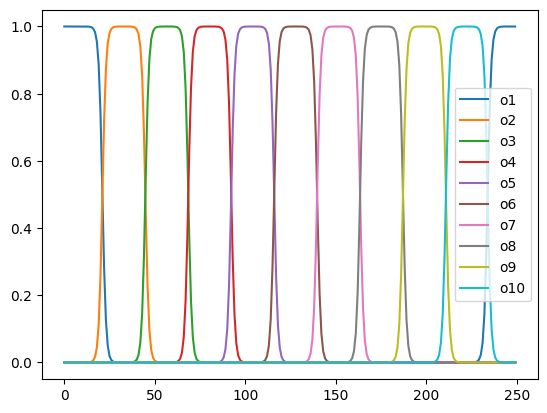

In [590]:
time = np.linspace(0,t_limit-1,t_limit)
for i in range(len(oscillating_species)):
    plt.plot(time, species_concentrations[oscillating_species[i]], label = oscillating_species[i])
plt.legend()
plt.show()

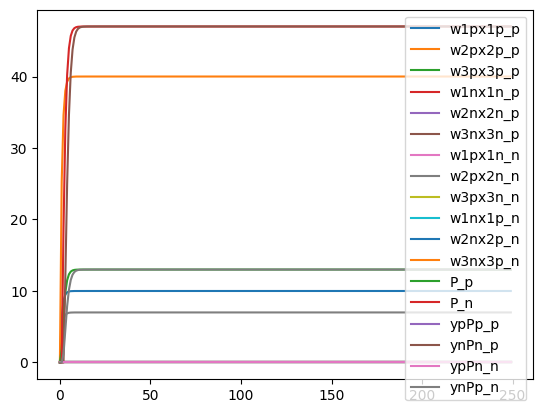

In [591]:
# plotting the results
time = np.linspace(0,t_limit-1,t_limit)
for i in range(12):
    plt.plot(time, species_concentrations[product_array[i]], label = product_array[i])
plt.plot(time, species_concentrations['P_p'], label = 'P_p')
plt.plot(time, species_concentrations['P_n'], label = 'P_n')
plt.plot(time, species_concentrations['ypPp_p'], label = 'ypPp_p')
plt.plot(time, species_concentrations['ynPn_p'], label = 'ynPn_p')
plt.plot(time, species_concentrations['ypPn_n'], label = 'ypPn_n')
plt.plot(time, species_concentrations['ynPp_n'], label = 'ynPp_n')
plt.legend()
plt.show()

In [592]:
# printing P
print(species_concentrations['P_p'][-1] - species_concentrations['P_n'][-1])

-33.99980198161949


In [593]:
# printing Q+  - (Q- + 1)
print(species_concentrations['Q_p'][-1] , species_concentrations['Q_n+K'][-1])

46.99942961944929 13.99965957004957


In [594]:
#  printing Q_gt_K, Q_lt_K and helper
print(species_concentrations['Q_gt_K'][-1])
print(species_concentrations['Q_lt_K'][-1])
print(species_concentrations['helper'][-1])

0.9081301286409036
0.1333132277783844
0.15176610776961813
